# 03 - Model Training

**Purpose**: Train models, compare, save best one.

**Inputs**: `data/processed/features_v1_*.csv`

**Outputs**: `models/model_v1.joblib`

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, SelectFromModel

from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    confusion_matrix, classification_report,
    fbeta_score, make_scorer, roc_auc_score
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

DATA_PATH = Path('../data/processed/preprocessed_v1.csv')
MODELS_PATH = Path('../models')
MODELS_PATH.mkdir(exist_ok=True)

# Constants
TARGET_COLUMN = 'recidiva_exitus'
RANDOM_STATE = 42
MAX_FEATURES = 14

In [ ]:
# Carreguem el dataset preprocessat
df = pd.read_csv(DATA_PATH)

# Separem features (X) i target (y)
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print(f"\n Distribució del Target:")
print(y.value_counts())
print(f"Ratio desbalanceig: 1:{(1-y.mean())/y.mean():.1f}")


🎯 Distribució del Target:
recidiva_exitus
0    120
1     34
Name: count, dtype: int64
Ratio desbalanceig: 1:3.5


In [3]:
def f2_score(y_true, y_pred):
    """F2-score: Dóna més pes al Recall (beta=2)"""
    return fbeta_score(y_true, y_pred, beta=2)

f2_scorer = make_scorer(fbeta_score, beta=2)

def evaluate_model(y_true, y_pred, model_name="Model"):
    metrics = {
        'Model': model_name,
        'F2-Score': fbeta_score(y_true, y_pred, beta=2),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred),
    }
    
    if len(np.unique(y_pred)) > 1:
        metrics['AUC'] = roc_auc_score(y_true, y_pred)
    else:
        metrics['AUC'] = np.nan
        
    return metrics

In [4]:
# Apliquem SMOTE abans del RF inicial
smote = SMOTE(random_state=RANDOM_STATE)
X_resampled, y_resampled = smote.fit_resample(X, y)

rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_baseline.fit(X_resampled, y_resampled)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 features per importància:")
print(feature_importance.head(20).to_string(index=False))


Top 20 features per importància:
                       feature  importance
    grupo_de_riesgo_definitivo    0.160022
               afectacion_linf    0.127007
               estadiaje_pre_i    0.091936
Tratamiento_sistemico_realizad    0.080661
               grado_histologi    0.079062
                           imc    0.068164
               infiltracion_mi    0.066063
                      FIGO2023    0.062369
                  rece_de_Ppor    0.054429
             recep_est_porcent    0.052192
                          edad    0.049652
               tto_1_quirugico    0.045726
                   histo_defin    0.039611
                metasta_distan    0.023104


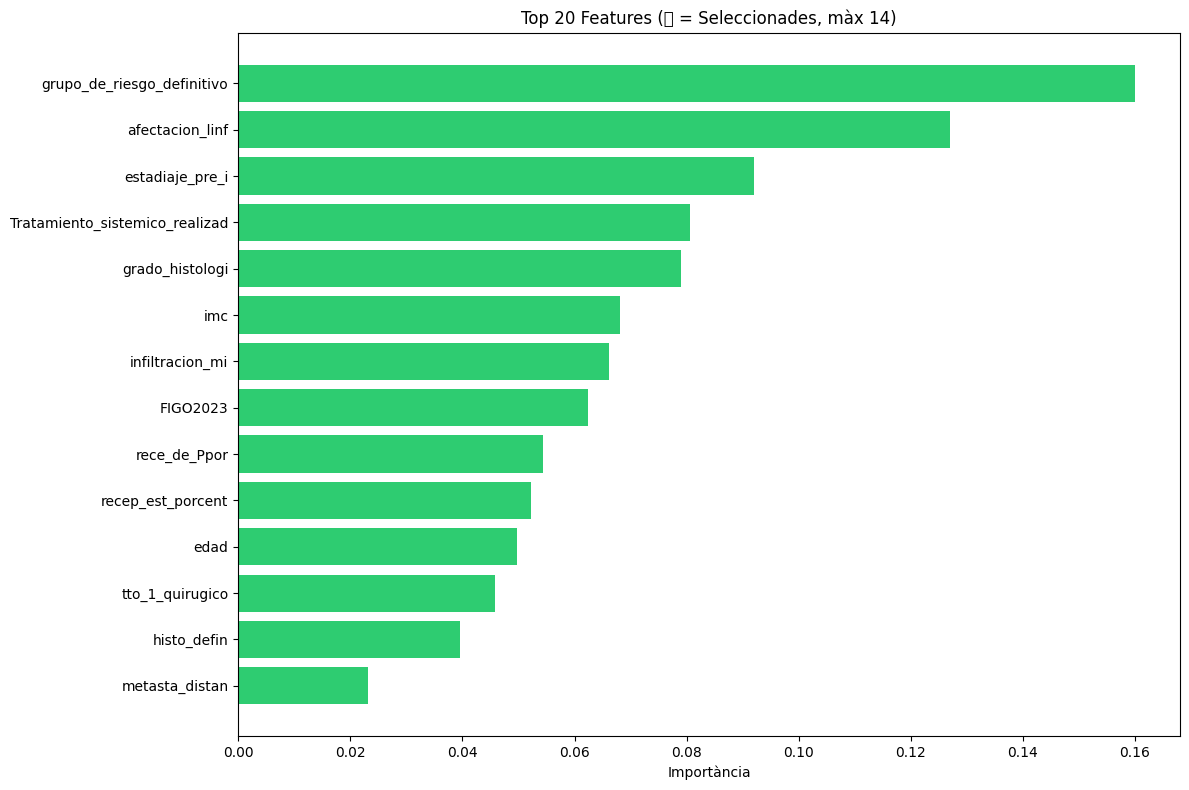


✅ 14 Features Seleccionades:
    1. grupo_de_riesgo_definitivo: 0.1600
    2. afectacion_linf: 0.1270
    3. estadiaje_pre_i: 0.0919
    4. Tratamiento_sistemico_realizad: 0.0807
    5. grado_histologi: 0.0791
    6. imc: 0.0682
    7. infiltracion_mi: 0.0661
    8. FIGO2023: 0.0624
    9. rece_de_Ppor: 0.0544
   10. recep_est_porcent: 0.0522
   11. edad: 0.0497
   12. tto_1_quirugico: 0.0457
   13. histo_defin: 0.0396
   14. metasta_distan: 0.0231


In [5]:
# Visualitzem les top 20 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)

colors = ['#2ecc71' if i < MAX_FEATURES else '#95a5a6' for i in range(len(top_features))]

plt.barh(
    y=range(len(top_features)), 
    width=top_features['importance'].values,
    color=colors
)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importància')
plt.title(f'Top 20 Features (🟢 = Seleccionades, màx {MAX_FEATURES})')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardem les top features
SELECTED_FEATURES = feature_importance.head(MAX_FEATURES)['feature'].tolist()
print(f"\n✅ {len(SELECTED_FEATURES)} Features Seleccionades:")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"   {i:2d}. {feat}: {imp:.4f}")

In [6]:
# Pas 2: Recursive Feature Elimination per refinar

X_selected = X[SELECTED_FEATURES]
X_res_sel, y_res_sel = smote.fit_resample(X_selected, y)

rf_rfe = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rfe = RFE(
    estimator=rf_rfe,
    n_features_to_select=MAX_FEATURES,
    step=1
)
rfe.fit(X_res_sel, y_res_sel)

rfe_ranking = pd.DataFrame({
    'feature': SELECTED_FEATURES,
    'ranking': rfe.ranking_,
    'selected': rfe.support_
}).sort_values('ranking')

print("\nRanking RFE:")
print(rfe_ranking.to_string(index=False))

# Features finals
FINAL_FEATURES = rfe_ranking[rfe_ranking['selected']]['feature'].tolist()
print(f"\nFeatures Finals: {len(FINAL_FEATURES)}")


Ranking RFE:
                       feature  ranking  selected
    grupo_de_riesgo_definitivo        1      True
               afectacion_linf        1      True
               estadiaje_pre_i        1      True
Tratamiento_sistemico_realizad        1      True
               grado_histologi        1      True
                           imc        1      True
               infiltracion_mi        1      True
                      FIGO2023        1      True
                  rece_de_Ppor        1      True
             recep_est_porcent        1      True
                          edad        1      True
               tto_1_quirugico        1      True
                   histo_defin        1      True
                metasta_distan        1      True

Features Finals: 14


In [7]:
# Preparem les dades amb les features finals
X_final = X[FINAL_FEATURES]

# Escalar les dades
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
X_scaled = pd.DataFrame(X_scaled, columns=FINAL_FEATURES)

print(f"Dades finals: {X_scaled.shape}")
print(f"Target: {y.shape}")
print(f"\nFeatures Finals:")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"   {i}. {f}")

Dades finals: (154, 14)
Target: (154,)

Features Finals:
   1. grupo_de_riesgo_definitivo
   2. afectacion_linf
   3. estadiaje_pre_i
   4. Tratamiento_sistemico_realizad
   5. grado_histologi
   6. imc
   7. infiltracion_mi
   8. FIGO2023
   9. rece_de_Ppor
   10. recep_est_porcent
   11. edad
   12. tto_1_quirugico
   13. histo_defin
   14. metasta_distan


In [8]:
# Definim els models a comparar
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=RANDOM_STATE
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    ),
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    'SVM': SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,
        random_state=RANDOM_STATE
    ),
    'Naive Bayes': GaussianNB()
}

print(f"Comparant {len(models)} models amb LOOCV + SMOTE")

Comparant 6 models amb LOOCV + SMOTE


In [9]:
# LOOCV amb SMOTE integrat
loo = LeaveOneOut()
results = []

for name, model in models.items():
    print(f"Avaluant {name}...")
    
    # Prediccions amb LOOCV
    y_pred_list = []
    y_true_list = []
    
    for train_idx, test_idx in loo.split(X_scaled):
        X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Apliquem SMOTE només al train
        smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=min(5, (y_train == 1).sum() - 1))
        try:
            X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        except ValueError:
            # Si no hi ha prou samples, usem les dades originals
            X_train_res, y_train_res = X_train, y_train
        
        # Entrenem i prediem
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        
        y_pred_list.append(y_pred[0])
        y_true_list.append(y_test.values[0])
    
    # Convertim a arrays
    y_true_arr = np.array(y_true_list)
    y_pred_arr = np.array(y_pred_list)
    
    # Avaluem
    metrics = evaluate_model(y_true_arr, y_pred_arr, name)
    results.append(metrics)
    
    print(f"    F2-Score: {metrics['F2-Score']:.4f} | Recall: {metrics['Recall']:.4f}")

# Resultats en DataFrame
results_df = pd.DataFrame(results).sort_values('F2-Score', ascending=False)
print("\n" + "="*60)
print("RESULTATS FINALS (ordenats per F2-Score)")
print("="*60)
print(results_df.to_string(index=False))

Avaluant Random Forest...
    F2-Score: 0.7386 | Recall: 0.7647
Avaluant XGBoost...
    F2-Score: 0.6609 | Recall: 0.6765
Avaluant Gradient Boosting...
    F2-Score: 0.6977 | Recall: 0.7059
Avaluant Logistic Regression...
    F2-Score: 0.7670 | Recall: 0.7941
Avaluant SVM...
    F2-Score: 0.8101 | Recall: 0.8529
Avaluant Naive Bayes...
    F2-Score: 0.7459 | Recall: 0.7941

RESULTATS FINALS (ordenats per F2-Score)
              Model  F2-Score   Recall  Precision  F1-Score      AUC
                SVM  0.810056 0.852941   0.674419  0.753247 0.868137
Logistic Regression  0.767045 0.794118   0.675000  0.729730 0.842892
        Naive Bayes  0.745856 0.794118   0.600000  0.683544 0.822059
      Random Forest  0.738636 0.764706   0.650000  0.702703 0.824020
  Gradient Boosting  0.697674 0.705882   0.666667  0.685714 0.802941
            XGBoost  0.660920 0.676471   0.605263  0.638889 0.775735


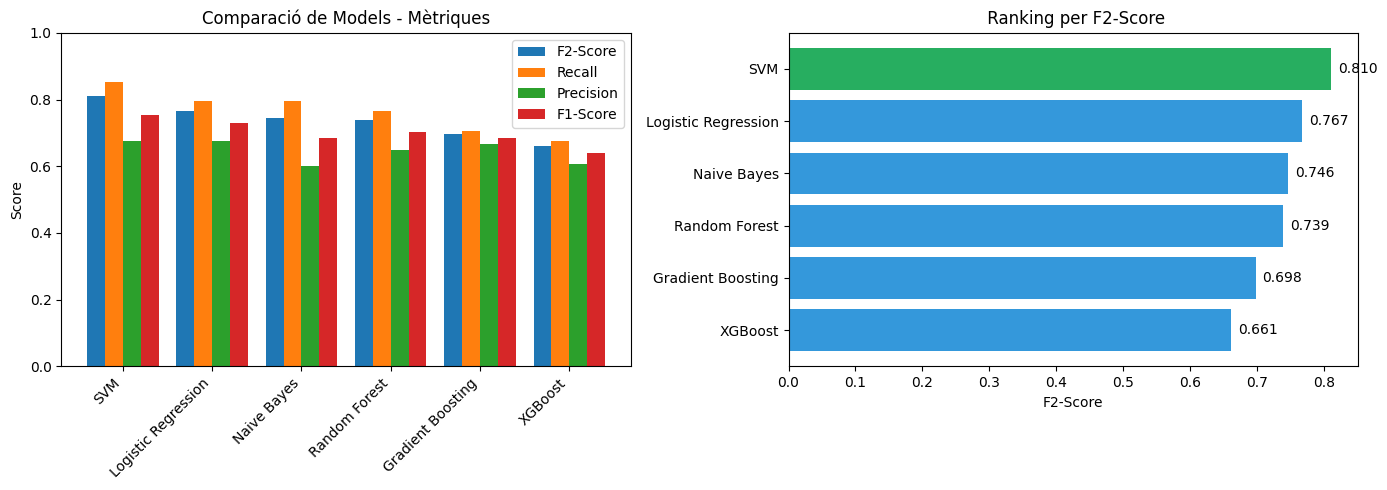


 MILLOR MODEL: SVM (F2-Score: 0.8101)


In [10]:
# Visualització de resultats
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gràfic 1: Comparació de mètriques
metrics_to_plot = ['F2-Score', 'Recall', 'Precision', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, results_df[metric], width, label=metric)

axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparació de Models - Mètriques')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Gràfic 2: F2-Score ranking
colors = ['#27ae60' if i == 0 else '#3498db' for i in range(len(results_df))]
axes[1].barh(results_df['Model'], results_df['F2-Score'], color=colors)
axes[1].set_xlabel('F2-Score')
axes[1].set_title(' Ranking per F2-Score')
axes[1].invert_yaxis()

for i, v in enumerate(results_df['F2-Score']):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Millor model
best_model_name = results_df.iloc[0]['Model']
best_f2 = results_df.iloc[0]['F2-Score']
print(f"\n MILLOR MODEL: {best_model_name} (F2-Score: {best_f2:.4f})")

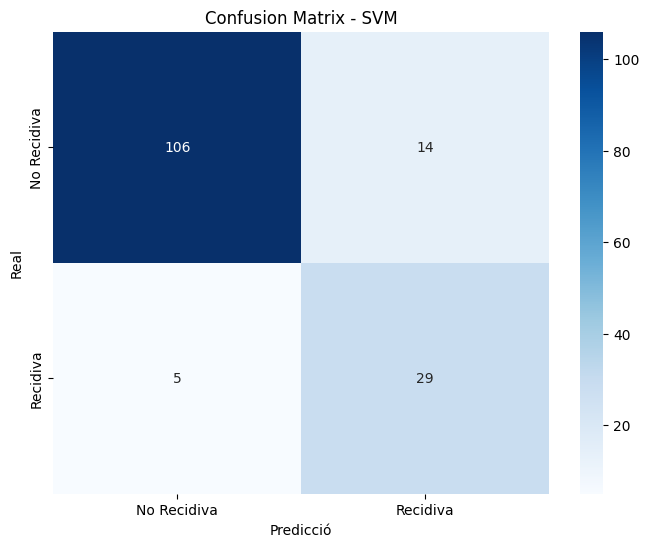


📋 Classification Report - SVM:
              precision    recall  f1-score   support

 No Recidiva       0.95      0.88      0.92       120
    Recidiva       0.67      0.85      0.75        34

    accuracy                           0.88       154
   macro avg       0.81      0.87      0.84       154
weighted avg       0.89      0.88      0.88       154



In [11]:
# Reentrenem el millor model per mostrar la CM
best_model = models[best_model_name]

# Prediccions finals amb LOOCV (ja calculades)
y_pred_best = []
for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=min(5, (y_train == 1).sum() - 1))
    try:
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    except ValueError:
        X_train_res, y_train_res = X_train, y_train
    
    best_model.fit(X_train_res, y_train_res)
    y_pred_best.append(best_model.predict(X_test)[0])

y_pred_best = np.array(y_pred_best)

# Confusion Matrix
cm = confusion_matrix(y, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Recidiva', 'Recidiva'],
            yticklabels=['No Recidiva', 'Recidiva'])
plt.xlabel('Predicció')
plt.ylabel('Real')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Classification Report
print(f"\n📋 Classification Report - {best_model_name}:")
print(classification_report(y, y_pred_best, target_names=['No Recidiva', 'Recidiva']))

In [12]:
# SMOTE amb totes les dades
smote_final = SMOTE(random_state=RANDOM_STATE)
X_final_res, y_final_res = smote_final.fit_resample(X_scaled, y)

# Model final
final_model = models[best_model_name]
final_model.fit(X_final_res, y_final_res)

# Guardem el model
model_path = MODELS_PATH / 'model_v1.joblib'
joblib.dump(final_model, model_path)
print(f" Model guardat: {model_path}")

# Guardem el scaler
scaler_path = MODELS_PATH / 'scaler_v1.joblib'
joblib.dump(scaler, scaler_path)
print(f" Scaler guardat: {scaler_path}")

# Guardem la llista de features
features_path = MODELS_PATH / 'selected_features_v1.joblib'
joblib.dump(FINAL_FEATURES, features_path)
print(f" Features guardades: {features_path}")

print(f"\n MODEL FINAL: {best_model_name}")
print(f" Features utilitzades ({len(FINAL_FEATURES)}):")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"   {i}. {f}")

 Model guardat: ..\models\model_v1.joblib
 Scaler guardat: ..\models\scaler_v1.joblib
 Features guardades: ..\models\selected_features_v1.joblib

 MODEL FINAL: SVM
 Features utilitzades (14):
   1. grupo_de_riesgo_definitivo
   2. afectacion_linf
   3. estadiaje_pre_i
   4. Tratamiento_sistemico_realizad
   5. grado_histologi
   6. imc
   7. infiltracion_mi
   8. FIGO2023
   9. rece_de_Ppor
   10. recep_est_porcent
   11. edad
   12. tto_1_quirugico
   13. histo_defin
   14. metasta_distan


In [13]:
# Resum final
print("="*60)
print("RESUM DEL TRAINING")
print("="*60)
print(f"""
Target: {TARGET_COLUMN}
Samples totals: {len(y)}
Casos positius (recidiva): {y.sum()} ({y.mean()*100:.1f}%)
Casos negatius: {(1-y).sum()} ({(1-y.mean())*100:.1f}%)

 METODOLOGIA:
   - Selecció de features: RF + RFE
   - Gestió desbalanceig: SMOTE + class_weight
   - Validació: Leave-One-Out CV (LOOCV)
   - Mètrica principal: F2-Score (prioritza Recall)

 MILLOR MODEL: {best_model_name}
   - F2-Score: {results_df.iloc[0]['F2-Score']:.4f}
   - Recall: {results_df.iloc[0]['Recall']:.4f}
   - Precision: {results_df.iloc[0]['Precision']:.4f}
   - F1-Score: {results_df.iloc[0]['F1-Score']:.4f}

 ARXIUS GENERATS:
   - models/model_v1.joblib
   - models/scaler_v1.joblib
   - models/selected_features_v1.joblib

📋 FEATURES FINALS ({len(FINAL_FEATURES)}):
""")
for i, f in enumerate(FINAL_FEATURES, 1):
    print(f"   {i:2d}. {f}")
    
print("\n Training completat")

RESUM DEL TRAINING

Target: recidiva_exitus
Samples totals: 154
Casos positius (recidiva): 34 (22.1%)
Casos negatius: 120 (77.9%)

 METODOLOGIA:
   - Selecció de features: RF + RFE
   - Gestió desbalanceig: SMOTE + class_weight
   - Validació: Leave-One-Out CV (LOOCV)
   - Mètrica principal: F2-Score (prioritza Recall)

 MILLOR MODEL: SVM
   - F2-Score: 0.8101
   - Recall: 0.8529
   - Precision: 0.6744
   - F1-Score: 0.7532

 ARXIUS GENERATS:
   - models/model_v1.joblib
   - models/scaler_v1.joblib
   - models/selected_features_v1.joblib

📋 FEATURES FINALS (14):

    1. grupo_de_riesgo_definitivo
    2. afectacion_linf
    3. estadiaje_pre_i
    4. Tratamiento_sistemico_realizad
    5. grado_histologi
    6. imc
    7. infiltracion_mi
    8. FIGO2023
    9. rece_de_Ppor
   10. recep_est_porcent
   11. edad
   12. tto_1_quirugico
   13. histo_defin
   14. metasta_distan

 Training completat
